In [2]:

import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Flatten, Dense, BatchNormalization, UpSampling2D, concatenate, MaxPooling2D,Reshape, Activation
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from sklearn.model_selection import train_test_split

tf.random.set_seed(123)
np.random.seed(1)

In [2]:
obj = 'img_align_celeba'
ImagePath= f"D:\\Private\\CODE\\kaggle\\image_colorization\\new_data\\{obj}"
SIZE = 128

LOAD DATA


In [3]:


def load_and_preprocess_image(image_path, img_size):
    try:
        rgb_image = Image.open(image_path).resize((img_size, img_size))
        rgb_img_array = np.asarray(rgb_image) / 255.0

        gray_image = rgb_image.convert('L')
        gray_img_array = np.asarray(gray_image).reshape((img_size, img_size, 1)) / 255.0
        
        return gray_img_array, rgb_img_array
    except Exception as e:
        return None, None

def data_train(image_path,size):
    x = []
    y = []

    for image_file in os.listdir(ImagePath)[:2000]:
        image_path = os.path.join(ImagePath, image_file)

        gray_img_array, rgb_img_array = load_and_preprocess_image(image_path, size)
        
        if gray_img_array is not None and rgb_img_array is not None:
        
            if gray_img_array.shape == (size, size, 1) and rgb_img_array.shape == (size, size, 3):
                x.append(gray_img_array)
                y.append(rgb_img_array)


    train_x, test_x, train_y, test_y = train_test_split(np.array(x), np.array(y), test_size=0.2, random_state=42)

    dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
    dataset = dataset.batch(16)

    return train_x, test_x, train_y, test_y,dataset

train_x, test_x, train_y, test_y, dataset = data_train(ImagePath,SIZE)

In [4]:
print(f'Train shape: {train_x.shape}')
print(f'Test shape: {test_x.shape}')

Train shape: (1600, 128, 128, 1)
Test shape: (400, 128, 128, 1)


GENERATOR & DISCRIMINATOR

In [5]:

def get_generator_model():
    
    Input_Sample = Input(shape=(SIZE, SIZE, 1))

    layers = Conv2D(16, (3, 3), padding='same', strides=1)(Input_Sample)
    layers = LeakyReLU()(layers)
    layers = Conv2D(32, (3, 3), padding='same', strides=1)(layers)
    layers = LeakyReLU()(layers)

    layers = Conv2D(64, (3, 3), padding='same', strides=1)(layers)
    layers = LeakyReLU()(layers)
    layers = BatchNormalization()(layers)
    
    layers = Conv2D(64, (5, 5), padding='same', strides=1)(layers)
    layers = LeakyReLU()(layers)
    layers = BatchNormalization()(layers)

    layers = Conv2D(128, (5, 5), padding='same', strides=1)(layers)
    layers = LeakyReLU()(layers)
    layers = BatchNormalization()(layers)
    layers = MaxPooling2D(pool_size=(2, 2))(layers)

    layers = UpSampling2D((2, 2))(layers)
    layers = Conv2D(256, (3, 3), padding='same', strides=1)(layers)
    layers = LeakyReLU()(layers)
    layers = BatchNormalization()(layers)

    concat = concatenate([layers, Input_Sample])

    layers = Conv2D(64, (3, 3), padding='same', strides=1)(concat)
    layers = LeakyReLU()(layers)
    layers = BatchNormalization()(layers)

    layers = Conv2D(32, (3, 3), padding='same', strides=1)(layers)
    layers = LeakyReLU()(layers)
    layers = BatchNormalization()(layers)

    output = Conv2D(3, (3, 3), activation='sigmoid', padding='same', strides=1)(layers)

    model = Model(inputs=Input_Sample, outputs=output)
    model.compile(optimizer="adam", loss='mse')
    return model


def get_discriminator_model():
    base_model2 = ResNet50V2(weights = "imagenet",
                                                       input_shape = (SIZE, SIZE, 3),
                                                       pooling = "max", include_top = False)
                                                    

    for layer in base_model2.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model2)
    model.add(Flatten())

    model.add(Dense(256, activation = "relu"))
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(64, activation = "relu"))
    model.add(Dense(32, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
      
    model.compile(optimizer = "adam", loss = "mse", metrics = ["accuracy"])
    return model


def Discriminator():
  
  def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[SIZE, SIZE, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[SIZE, SIZE, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [6]:

generator = get_generator_model()
discriminator = get_discriminator_model()

GENERATOR SUMMARY


In [7]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

DISCRIMINATOR SUMMARY

In [8]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 3

GAN

Epoch 1/50 - Generator Loss: 0.0133, Discriminator Loss: 0.7101
Epoch 2/50 - Generator Loss: 0.0088, Discriminator Loss: 0.5935
Epoch 3/50 - Generator Loss: 0.0081, Discriminator Loss: 0.6222
Epoch 4/50 - Generator Loss: 0.0079, Discriminator Loss: 0.6590
Epoch 5/50 - Generator Loss: 0.0077, Discriminator Loss: 0.6411
Epoch 6/50 - Generator Loss: 0.0075, Discriminator Loss: 0.5951
Epoch 7/50 - Generator Loss: 0.0074, Discriminator Loss: 0.6219
Epoch 8/50 - Generator Loss: 0.0073, Discriminator Loss: 0.7220
Epoch 9/50 - Generator Loss: 0.0072, Discriminator Loss: 0.7336
Epoch 10/50 - Generator Loss: 0.0072, Discriminator Loss: 0.7261
Epoch 11/50 - Generator Loss: 0.0071, Discriminator Loss: 0.7109
Epoch 12/50 - Generator Loss: 0.0070, Discriminator Loss: 0.6664
Epoch 13/50 - Generator Loss: 0.0070, Discriminator Loss: 0.6474
Epoch 14/50 - Generator Loss: 0.0069, Discriminator Loss: 0.6435
Epoch 15/50 - Generator Loss: 0.0069, Discriminator Loss: 0.6485
Epoch 16/50 - Generator Loss: 0.00

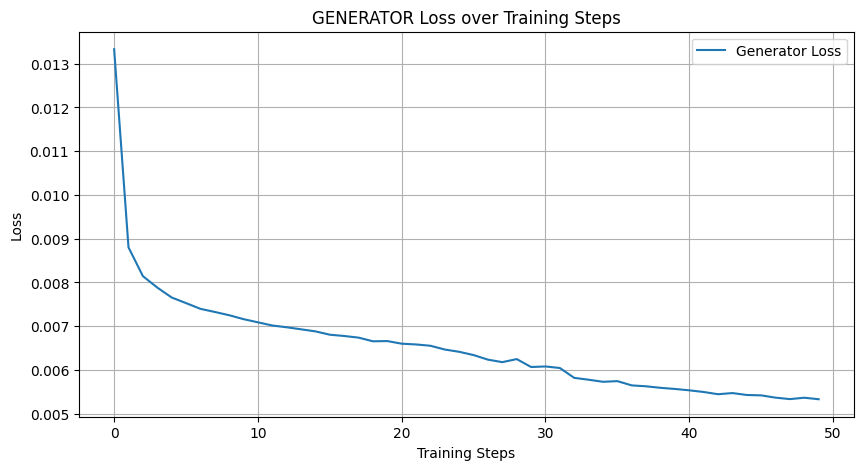

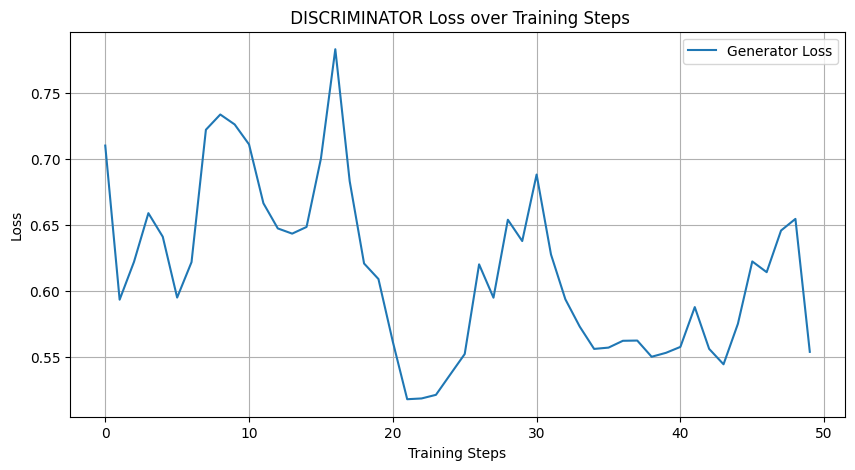

In [9]:
import tensorflow as tf

class GAN:
    def __init__(self, generator, discriminator, cross_entropy, mse):
        
        self.generator = generator
        self.discriminator = discriminator
        self.cross_entropy = cross_entropy
        self.mse = mse
        self.generator_optimizer = Adam()
        self.discriminator_optimizer = Adam()
        
        self.gen_losses = []
        self.dis_losses = []

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output) - tf.random.uniform(shape=real_output.shape, maxval=0.1), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform(shape=fake_output.shape, maxval=0.1), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output, real_y):
        real_y = tf.cast(real_y, 'float32')
        return self.mse(fake_output, real_y)


    @tf.function
    def train_step(self, input_x, real_y):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(input_x, training=True)
            
            real_output = self.discriminator(real_y, training=True)
            generated_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(generated_images, real_y)
            disc_loss = self.discriminator_loss(real_output, generated_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        
        return gen_loss, disc_loss
    def train(self, dataset, epochs):
        for epoch in range(epochs):
            gen_loss_total = 0
            disc_loss_total = 0
            batch_count = 0
            
            for (x, y) in dataset:
                gen_loss, disc_loss = self.train_step(x, y)
                gen_loss_total += gen_loss
                disc_loss_total += disc_loss
                batch_count += 1
            
            avg_gen_loss = gen_loss_total / batch_count
            avg_disc_loss = disc_loss_total / batch_count

            self.gen_losses.append(avg_gen_loss)
            self.dis_losses.append(avg_disc_loss)

            print(f"Epoch {epoch + 1}/{epochs} - Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}")


    
    def plot_loss(self,losses, model):
        plt.figure(figsize=(10, 5))
        plt.plot(losses, label='Generator Loss')
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.title(f'{model} Loss over Training Steps')
        plt.legend()
        plt.grid()
        plt.show()

with tf.device('/gpu:0'):
    cross_entropy = tf.keras.losses.BinaryCrossentropy()
    mse = tf.keras.losses.MeanSquaredError()
    gan = GAN(generator, discriminator, cross_entropy, mse)
    gan.train(dataset, epochs=50)
    # gan.generator.save(f"./save_model/{obj}/{obj}.keras")
    gan.plot_loss(gan.gen_losses, 'GENERATOR')
    gan.plot_loss(gan.dis_losses, ' DISCRIMINATOR')


In [10]:
# generator = tf.keras.models.load_model(f"D:\\Private\\CODE\\kaggle\\image_colorization\\save_model\\{obj}\\{obj}.keras")


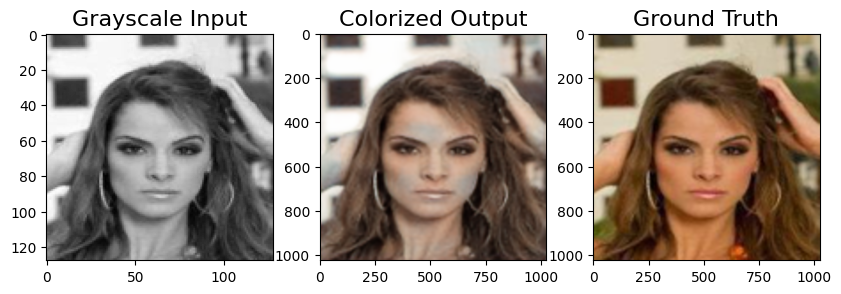

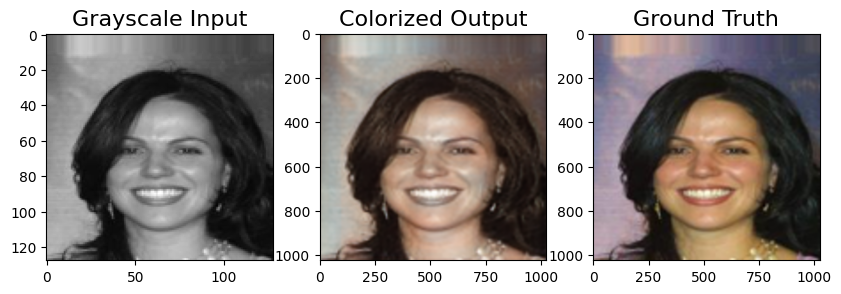

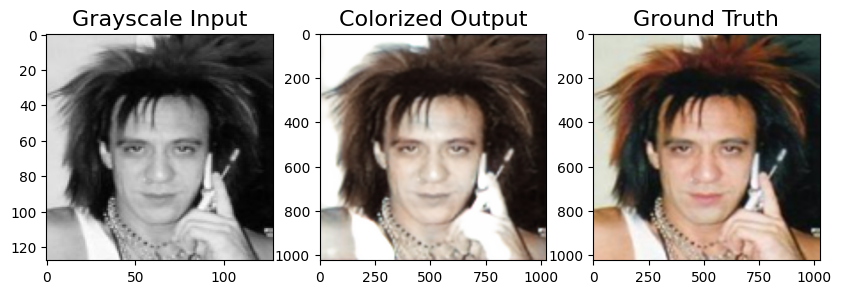

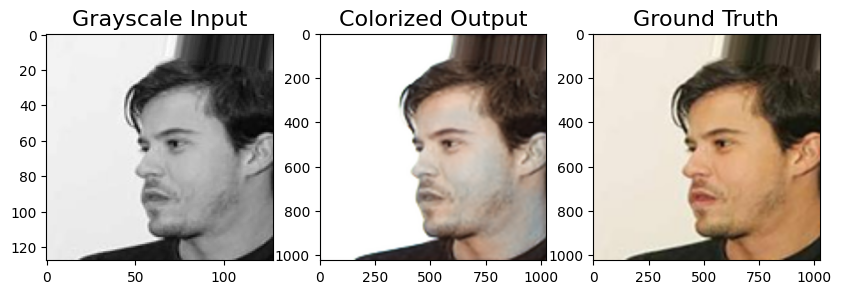

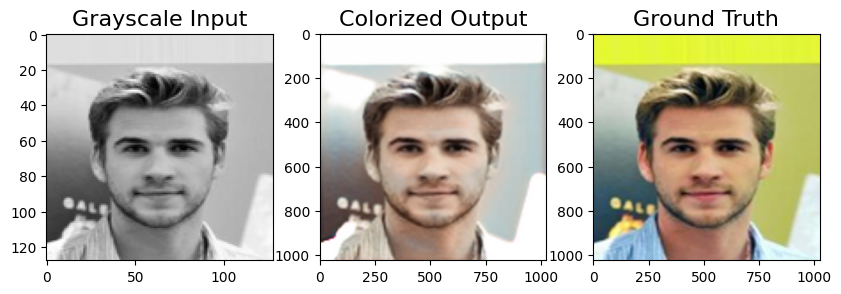

In [11]:
y = generator(test_x[:5]).numpy()

for i in range(len(test_x[:5])):
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow( test_x[i].reshape((SIZE,SIZE)) , cmap='gray' )

  in_image = plt.subplot(3,3,2)    
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )
  

  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )
  plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Private\\CODE\\kaggle\\image_colorization\\RESULT\\img_align_celeba\\COLORIZED\\img_align_celeba0.png'

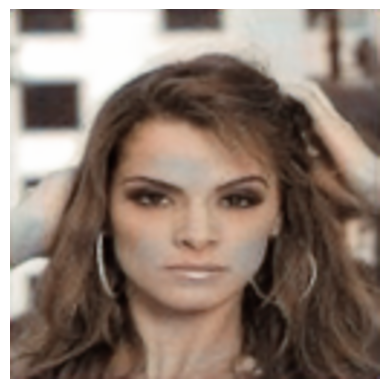

In [12]:
y = generator(test_x[:50]).numpy()

for i in range(len(test_x[:50])):
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  plt.imshow(image)
  plt.axis('off')
  plt.savefig(f'./RESULT/{obj}/COLORIZED/{obj}{i}.png', bbox_inches='tight', pad_inches=0)
  plt.close()

for i in range(len(test_x[:50])):
  image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  plt.imshow(image)
  plt.axis('off')
  plt.savefig(f'./RESULT/{obj}/REAL/{obj}_{i}.png', bbox_inches='tight', pad_inches=0)
  plt.close()
  

In [ ]:
import torch
from torchvision import models, transforms
from torchmetrics.image import FrechetInceptionDistance

inception_v3_model = models.inception_v3(pretrained=True)
inception_v3_model.eval()  

preprocess_inception_v3 = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
])

def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(img_path).convert('RGB')
            images.append(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return images

def preprocess_images(images):
    preprocessed_images = []
    for img in images:
        img_tensor = preprocess_inception_v3(img).unsqueeze(0)  
        img_tensor = (img_tensor * 255).byte()  
        preprocessed_images.append(img_tensor)
    return torch.cat(preprocessed_images)  

fid = FrechetInceptionDistance(192)

real_images_folder = f'./RESULT/{obj}/REAL'
colorized_images_folder = f'./RESULT/{obj}/COLORIZED'
real_images = load_images_from_folder(real_images_folder)
colorized_images = load_images_from_folder(colorized_images_folder)
real_images_tensor = preprocess_images(real_images)
colorized_images_tensor = preprocess_images(colorized_images)
fid.update(real_images_tensor, real=True)
fid.update(colorized_images_tensor, real=False)
# Compute FID
fid_score = fid.compute()
print(f"FID Score: {fid_score}")

d:\Private\New folder\anconda\envs\tensorflowgpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Private\New folder\anconda\envs\tensorflowgpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID Score: 7.431879997253418


In [ ]:
#Coast 89 Desert 140.26 Forest 119.90 Glacier 102.17 Moutain 97

In [ ]:

# SIZE = 128 
# # 
# photo_filename = 'a.png'

# def load_and_preprocess_image(image_path, img_size):
#     try:
#         rgb_image = Image.open(image_path).resize((img_size, img_size))

#         rgb_img_array = np.asarray(rgb_image) / 255.0

#         gray_image = rgb_image.convert('L')
#         gray_img_array = np.asarray(gray_image).reshape((img_size, img_size, 1)) / 255.0
        
#         return np.expand_dims(gray_img_array, axis=0), rgb_img_array
#     except Exception as e:
#         return None, None    

# test_image,real_images = load_and_preprocess_image(photo_filename,128)
# colorized_image = generator(test_image).numpy()

# plt.figure(figsize=(15, 5))

# plt.subplot(1, 3, 1)
# plt.title('Grayscale Input', fontsize=16)
# plt.imshow(test_image[0].reshape((SIZE, SIZE)), cmap='gray')
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.title('Colorized Output', fontsize=16)
# colorized_resized = Image.fromarray((colorized_image[0] * 255).astype('uint8')).resize((1024, 1024))
# plt.imshow(colorized_resized)
# plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.title('Ground Truth', fontsize=16)
# ground_truth_resized = Image.fromarray((real_images * 255).astype('uint8')).resize((1024, 1024))
# plt.imshow(ground_truth_resized)
# plt.axis('off')

# plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential
import numpy as np

# Tạo mô hình đơn giản với 1 lớp Conv2D
model = Sequential([
    Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3))
])

# In ra mô hình
model.summary()

# Truy xuất kernel (filter) của lớp Conv2D
kernels = model.layers[0].get_weights()[0]

# In kernel
print("Kernel shape:", kernels.shape)
print("Kernel values:\n", kernels)

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________
Kernel shape: (3, 3, 3, 16)
Kernel values:
 [[[[-0.13951701 -0.00634849 -0.05222984  0.09253904 -0.09102807
     0.03340676 -0.00286859 -0.03944477  0.04084843  0.03423373
    -0.17959408  0.01080827 -0.15139896 -0.01292336  0.15005028
     0.1033279 ]
   [ 0.05074029  0.09300882  0.01486929  0.16904742  0.0434501
    -0.00786345  0.14387283  0.06076799  0.14396602 -0.04228631
    -0.18279195 -0.06454083 -0.17832838 -0.11790229 -0.08085249
     0.1040459 ]
   [ 0.16544989  0.1747596  -0.1666779  -0.15639234 -0.04133341
     0.01588815 -0.07194968 -0.04720242  0.04048356 -0.070